# Working in a transformed parameter space

This example shows you how to run a global optimisation with a transformed parameter space.

For a more elaborate example of an optimisation, see: [basic optimisation example](./first-example.ipynb).

First we will create a toy model which implements the logistic model.

In [1]:
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt
import math

model = toy.LogisticModel()

The parameters for the toy logistic model are $[r, K]$, where $r$ is the rate and $K$ is the carrying capacity. We will create a pints transformation that makes the optimiser to search in $[\log(r), \log(K)]$ space.

In [2]:
transform = pints.LogTransform()

Now all we have to do is to pass the pints transformation to pints optimisation, we can use it in combination with all of pints' optimisation and inference algorithms. For now, we will use it to fit simulated data using CMA-ES:

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      1.58e+07   0:00.0
1     12     1.53e+07   0:00.0
2     18     1.51e+07   0:00.0
3     24     1.49e+07   0:00.0
20    126    104412.2   0:00.1
40    246    92180.16   0:00.1
60    366    92179.76   0:00.1
80    486    92179.76   0:00.1
100   606    92179.76   0:00.2
120   726    92179.76   0:00.2
140   846    92179.76   0:00.2
160   966    92179.76   0:00.3
180   1086   92179.76   0:00.3
200   1206   92179.76   0:00.3
220   1326   92179.76   0:00.3
240   1446   92179.76   0:00.3
260   1566   92179.76   0:00.4
280   1686   92179.76   0:00.4
300   1806   92179.76   0:00.4
320   1926   92179.76   0:00.5
340   2046   92179.76   0:00.5
360   2166   92179.76   0:00.5
367   2202   92179.76   0:00.5
Halting: No significant change for 200 iterations.
Score at true solution: 
92282.7286643545
Found solution:          Tru

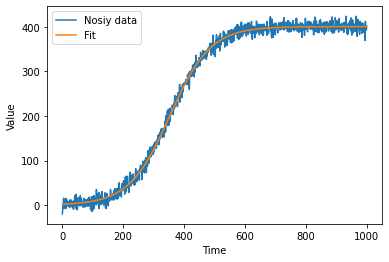

In [3]:
# Create some toy data
real_parameters = [0.015, 400]
times = np.linspace(0, 1000, 1000)
values = model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.RectangularBoundaries([0, 0.05], [0.03, 1000.0])

# Perform an optimization with boundaries and hints
x0 = 0.01,300.0
sigma0 = [0.01, 2.0]
found_parameters, found_value = pints.optimise(
    score,
    x0,
    sigma0,
    boundaries,
    method=pints.CMAES,
    transform=transform,
)

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

# Show quality of fit
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(times, values, label='Nosiy data')
plt.plot(times, problem.evaluate(found_parameters), label='Fit')
plt.legend()
plt.show()